In [1]:
## package imports ##

import sys
sys.path.append("../PythonScripts")
from preprocessing_utils import preprocess
from utils import save_to_synapse, get_file_entity
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import synapseclient as sc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import warnings
import os
import scipy.stats as stats
from pymatch.Matcher import Matcher
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

warnings.simplefilter("ignore")
sns.set_style("dark")
np.random.seed(100)
%matplotlib inline

Welcome, aryton tediarjo!



In [25]:
## helper functions ## 


"""
Function to annotate phone types
returns an annotated dataset with lesser choice of phonetypes
"""
def annot_phone(params):
    
    if ";" in params:
        params = params.split(";")[0]
    if ("iPhone 6+" in params) or ("iPhone 6 Plus" in params):
        return "iPhone 6+"
    if ("iPhone9" in params) or ("Unknown" in params) :
        return "Other iPhone"
    if ("iPhone 5" in params):
        return "iPhone 5"
    if ("iPhone8" in params):
        return "iPhone 8"
    if ("iPhone X" in params):
        return "iPhone X"
    return params


    
"""
Function to plot several metadata information accross version 
"""
def show_distribution(data, target):
    
    dataV1 = data[data["version"] == "V1"]
    dataV2 = data[data["version"] == "V2"]

    fig, axes = plt.subplots(nrows = 1, ncols = 3)

    sns.distplot(dataV2["age"].dropna(), label = "V2", ax = axes[0])
    sns.distplot(dataV1["age"].dropna(), label = "V1", ax = axes[0])
    axes[0].legend()
    axes[0].set_title("Age distribution of V1 and V2")
    axes[0].grid()
    axes[0].figure.set_size_inches(15,5)

    sns.countplot(data["PD"], hue = data["version"], ax = axes[1])
    axes[1].legend()
    axes[1].set_title("PD distribution of V1 and V2")
    axes[1].grid()
    axes[1].figure.set_size_inches(15,5)
    
    sns.countplot(data["gender"], hue = data["version"], ax = axes[2])
    axes[2].legend()
    axes[2].set_title("gender distribution of V1 and V2")
    axes[2].grid()
    axes[2].figure.set_size_inches(15,5)
    

    
"""
Function to implement PCA with 2 components, 
then separate them with a target hue variable to see differences

returns PCA-1 vs PCA-2 plots of metadata and walking features 
separated by its groups (PD, version)
"""    
    
def PCA_plotter(data, feat_cols, 
                metadata_cols, target):
    scaler = StandardScaler()
    X_feat = data[feat_cols]
    X_metadata = data[metadata_cols]
    y = data[["version", "healthCode", "PD"]]
    
    lr = LogisticRegression(random_state = 100)
    gb = GradientBoostingClassifier(random_state = 100)
    X_train, X_test, y_train, y_test = train_test_split(X_feat, y[target],
                                                        test_size = 0.2,
                                                        random_state = 100)
    
    gb.fit(X_train, y_train)
    
    print(classification_report(gb.predict(X_test), y_test))
    
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
    
    #Plotting the Cumulative Summation of the Explained Variance
    X_scaled = scaler.fit_transform(X_feat)
    pca = PCA().fit(X_scaled)
    pca = PCA(n_components = 3)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    principal_df = pd.concat([principal_df, y], axis = 1)
    
    sns.scatterplot(principal_df[0], principal_df[1], 
                    hue = principal_df[target], ax = axes[0])
    axes[0].set_title("PCA plot")
    axes[0].set_ylabel("PC2")
    axes[0].set_xlabel("PC1")
    axes[0].grid()
    
    
    #Plotting the Cumulative Summation of the Explained Variance
    X_scaled = scaler.fit_transform(X_metadata)
    pca = PCA().fit(X_scaled)
    pca = PCA(n_components = 3)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    principal_df = pd.concat([principal_df, y], axis = 1)
    
    sns.scatterplot(principal_df[0], principal_df[1], 
                    hue = principal_df[target], ax = axes[1])
    axes[1].set_title("PCA plot")
    axes[1].set_ylabel("PC2")
    axes[1].set_xlabel("PC1")
    axes[1].grid()
    
    plt.show()
    

"""
Function to one-hot encode the metadata
it will encode factorial and categorical variables (phonetype, gender and versions)
returns the encoded dataset, and the result of the encoded columns
"""
    
def OHE_data(data):

    metadata_df = data
    metadata_cols = [feat for feat in metadata_df.columns if ("." not in feat) and ("healthCode" not in feat)]
    # metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["version"])], axis = 1) 
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["phone_type"], 
                                                         prefix = "OHE_is")], axis = 1) 
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["gender"], 
                                                         drop_first = True, 
                                                         prefix = "OHE_is")], axis = 1)
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["version"], 
                                                         drop_first = True, 
                                                         prefix = "OHE_is")], axis = 1)
    OHE_meta_cols = [feat for feat in metadata_df.columns if ("OHE" in feat) or ("age" in feat) or ("PD" in feat)]
    return metadata_df, OHE_meta_cols



"""
Function to create paired healthcodes
takes in a dataset of PDKIT features

matching methods:
Join version 1 and version 2 table by leveraging phone types and gender
Iterate through each healthcode pairs, and prioritize healthcode pairs that have smaller age differences

Note: Not joining by PD status due to the non-PD data being discarded significantly

"""

def balance_hc(data):
    
    
    ref = pd.pivot_table(data = data, index = "phone_type", columns = "version", values = "PD", aggfunc = "count")
    list_of_spans = ref.loc[(ref["V1"] > 0) & (ref["V2"] > 0)].index
    data = data[data["phone_type"].isin(list_of_spans)].reset_index(drop = True)
    
    
    hcx_used = []
    hcy_used = []

    V1 = data[data["version"] == "V1"][["healthCode", "version", "phone_type", "gender", "PD", "age"]]
    V2 = data[data["version"] == "V2"][["healthCode", "version", "phone_type", "gender", "PD", "age"]]
    tst_data = pd.merge(V1, V2, on = ["phone_type", "gender"], how = "inner")
    tst_data["age_diff"] = np.abs(tst_data["age_x"] - tst_data["age_y"])
    tst_data = tst_data.sort_values("age_diff").reset_index(drop = True)


    for hc_x, hc_y in zip(tst_data["healthCode_x"], tst_data["healthCode_y"]):

        if (hc_y not in hcy_used) and (hc_x not in hcx_used):
            hcy_used.append(hc_y)
            hcx_used.append(hc_x)

    lst = hcx_used + hcy_used
    return data[data["healthCode"].isin(lst)]



"""
a function to get K-Nearest Neighbor from user in version 1 to version 2

##  pseudocode  ##
for each healthcode in user 1, find K other pair that is similar in "insert here" similarity metrics
afterwards, filter the data to only pair the healthcode in version 1 to those in version 2
then collect all the unique healthcodes that is left after the filter
"""

def getKNN_user2user(data, no_neighbors, 
                     distance_metrics, 
                     cols_used):
    data_v1 = data[data["version"] == "V1"]
    data_v2 = data[data["version"] == "V2"]
    data = data.set_index("healthCode")
    min_max_scaler = MinMaxScaler()
    walking_features = min_max_scaler.fit_transform(data[cols_used])
    nbrs = NearestNeighbors(n_neighbors = no_neighbors, 
                            algorithm = 'auto', 
                            metric = distance_metrics).fit(walking_features)
    distance, indices = nbrs.kneighbors(walking_features)
    _dict = {}
    _dict["healthCode_ref"] = []
    _dict["healthCode_pair"] = []
    _dict["distance"] = []
    data = data.reset_index()
    for dist, indice in zip(distance, indices):
        for healthcode_idx, _dist in zip(indice[1:], dist[1:]):
            _dict["healthCode_ref"].append(data.ix[indice[0]]["healthCode"])
            _dict["distance"].append(_dist)
            _dict["healthCode_pair"].append(data.ix[healthcode_idx]["healthCode"])
    matches = pd.DataFrame(_dict).sort_values(by = "distance", ascending = False)
    v2_list = data[data["version"] == "V2"]["healthCode"].unique()
    matches = matches[(~matches["healthCode_ref"].isin(v2_list)) \
        & (matches["healthCode_pair"].isin(v2_list))]
    matched_data = data[(data["healthCode"].isin(matches["healthCode_ref"].unique())) \
                | (data["healthCode"].isin(matches["healthCode_pair"].unique()))].reset_index(drop = True)
    return matched_data


def QaD_correlation(values, classes, isFactor=None):
    """Given a set of values or class assignments determines correlation/enrichment 
    in list of classificiations.
    Uses, correlation or fisher tests
    
    Arguments:
    - `values`:  Vector of values (either numeric or factors)
    - `classes`:  a two dimensional array or pandas DataFrame of (either numeric or factors)
    - `isFactor`: list of same length as classes of T/F indicating weather each 
                  class is a factor or continuous variable (defaults to None) meaning
                  strings are used factors and numbers as continuous
    Returns a list of p-values one for each classification in classes
    """

    isFactor = [None]*len(classes) if isFactor==None else isFactor
    pVals = []
    classes = pd.DataFrame(classes)
    for i, key in enumerate(classes):
        classification = classes[key]
        #If it is a factor perform ANOVA across groups
        if ((classification.dtype in [np.string_,  np.object_, np.bool_, np.unicode_]) or 
            isFactor[i]):
            groupLabels = list(set(classification.dropna()))
            groups = [values[np.where(classification==l)] for l in groupLabels]
            f_val, p_val = stats.f_oneway(*groups) 
            #if np.isnan(p_val):
            #    print groupLabels
            pVals.append(p_val)
            #print list(set(classification)), p_val
        #If it is not a factor perform correlation analysis
        else:
            m, b, r_val, p_val, slope_std_error = stats.linregress(values, classification)
            pVals.append(p_val)
    pVals = np.asarray(pVals)
    pVals[np.isnan(pVals)] = np.inf
    series = pd.Series(data = pVals, index = classes.columns)
    return series

In [18]:
## retrieve datasets ##


### retrieve version 1 data ###
dataV1 = get_file_entity("syn21046180")
dataV1 = preprocess(dataV1, "max", True)
dataV1["version"] = "V1"


### retrieve data from mPower version 2 ###
### side note: some data are prune to match the distribution to those in V1 ###
dataV2 = get_file_entity("syn21046181")
dataV2 = preprocess(dataV2, "max", True)
dataV2 = dataV2[dataV2["age"] >= dataV1["age"].min()]
dataV2["version"] = "V2"


### retrieve passive data ####
dataPassive = get_file_entity("syn21046184")
dataPassive["version"] = "Passive"

## concatenate dataset and annotate iphone type ## 
data = pd.concat([dataV1, dataV2]).reset_index()
data["phone_type"] = data["phoneInfo"].apply(annot_phone)

# Type of phones that span accross versions 

In [19]:
pd.pivot_table(data = data, index = "phone_type", columns = "version", values = "PD", aggfunc = "count")

version,V1,V2
phone_type,,
Other iPhone,2.0,19.0
iPhone 5,47.0,9.0
iPhone 6,90.0,39.0
iPhone 6+,49.0,12.0
iPhone 6S,NaN,26.0
iPhone 6S+,NaN,12.0
iPhone 7,NaN,36.0
iPhone 7+,NaN,25.0
iPhone 8,4.0,33.0


## 1.) Pre-matching Dataset

In [20]:
## get encoded data
encoded_data = OHE_data(data)[0]

## column feature lists
walking_feat_cols = [feat for feat in data.columns if "." in feat]
metadata_feat_cols = [feat for feat in data.columns if ("." not in feat) and ("healthCode" not in feat)]
OHE_feat_cols = OHE_data(data)[1]

              precision    recall  f1-score   support

          V1       0.92      0.92      0.92        38
          V2       0.94      0.94      0.94        54

    accuracy                           0.93        92
   macro avg       0.93      0.93      0.93        92
weighted avg       0.93      0.93      0.93        92



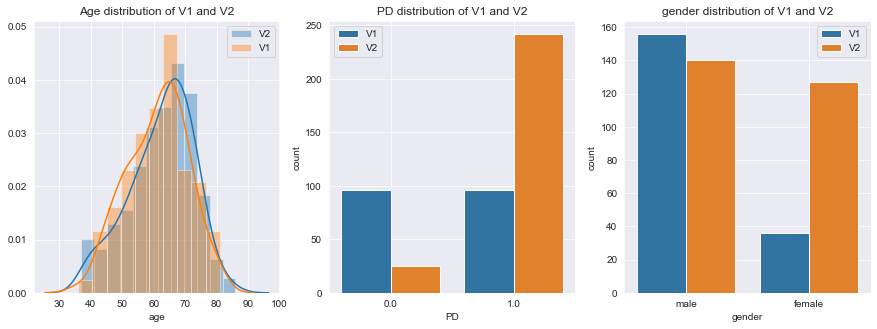

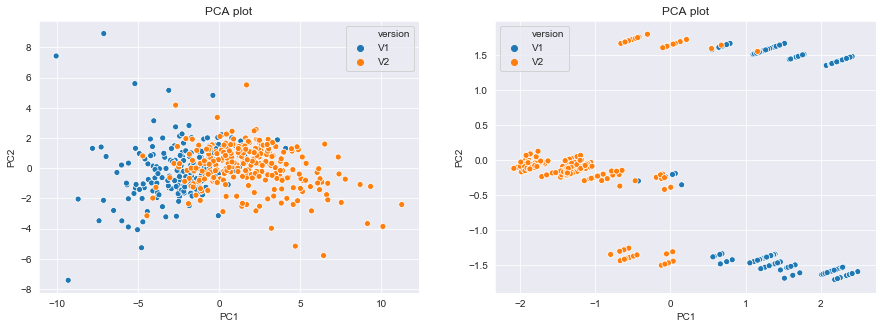

In [21]:
show_distribution(encoded_data[metadata_feat_cols], "version")
PCA_plotter(encoded_data, walking_feat_cols, OHE_feat_cols, "version")

## 2.) Matched Dataset

              precision    recall  f1-score   support

          V1       0.92      0.86      0.89        14
          V2       0.85      0.92      0.88        12

    accuracy                           0.88        26
   macro avg       0.88      0.89      0.88        26
weighted avg       0.89      0.88      0.88        26



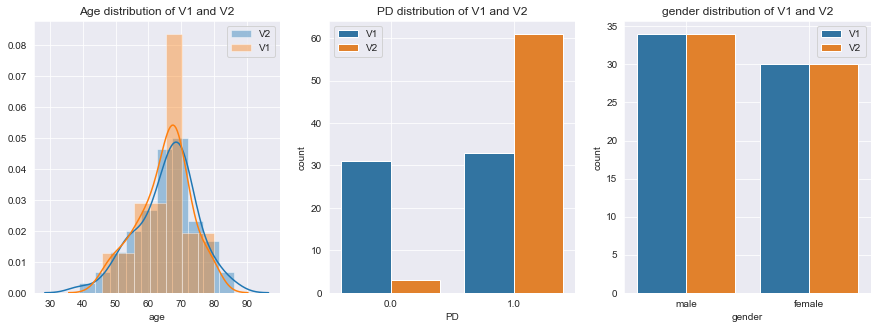

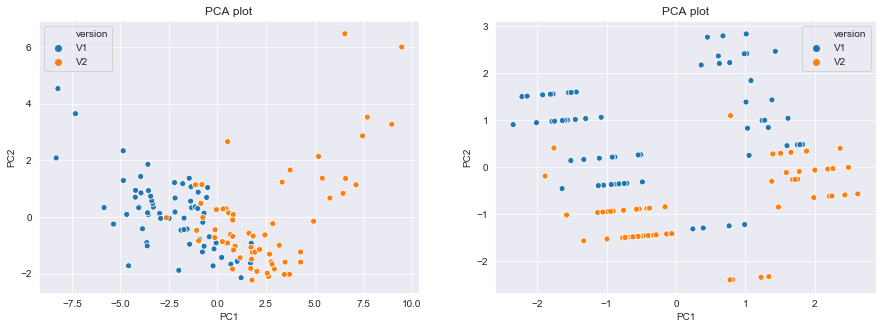

In [22]:
balance_hc_data = balance_hc(encoded_data).reset_index(drop = True)
show_distribution(balance_hc_data[metadata_feat_cols], "version")
PCA_plotter(balance_hc_data, walking_feat_cols, OHE_feat_cols, "version")

As seen from the PCA plot above, it is apparent that versioning has confounding effects towards our features as the first principal component and the second principal component (which explains most the data's variance) shows that there are separability between the two versions. Additionally, a simple logistic regression is also able to perfectly predict the versions, which is a strong indication that app version is a confounding variable. Therefore, our goal is to convolute the confounding effects of versioning. 

# Use Similarity Metrics to Convolute and Prune the healthCodes

In [23]:
matched_data = getKNN_user2user(data, 5, "euclidean", walking_feat_cols)
matched_data_encoded = OHE_data(matched_data)[0]

              precision    recall  f1-score   support

          V1       0.83      0.88      0.86        17
          V2       0.87      0.81      0.84        16

    accuracy                           0.85        33
   macro avg       0.85      0.85      0.85        33
weighted avg       0.85      0.85      0.85        33



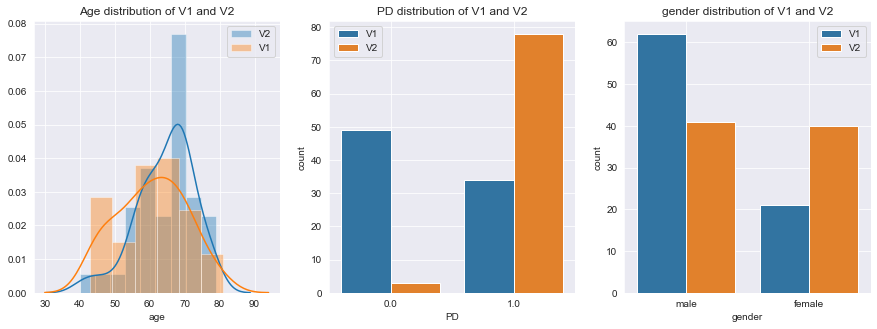

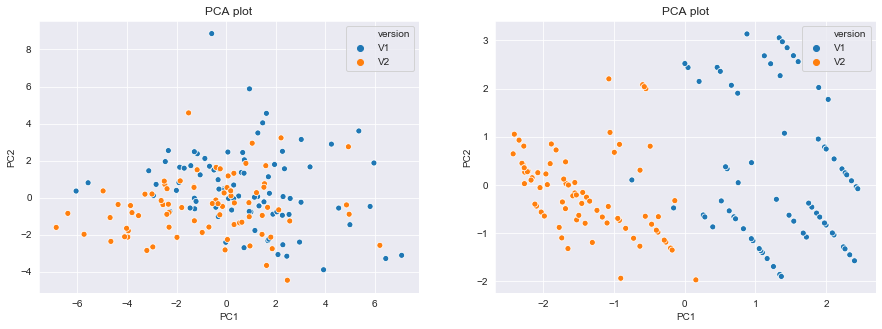

In [24]:
show_distribution(matched_data_encoded, "version")
PCA_plotter(matched_data_encoded, walking_feat_cols, OHE_feat_cols, "version")

The graph above shows that by pruning based on similarities, we are able to convolute the separation between the features, additionally, we can see that our logistic regression prediction performance was not as good as the ones before the healthcode pruning. 

# Metadata Association Analysis


# One-Way Anova Association on Metadata

## 1.) Before Matching

In [26]:
## association in gender groupings
metadata_df = OHE_data(data)[0]
OHE_cols = OHE_data(data)[1]
QaD_correlation(metadata_df["OHE_is_male"], metadata_df[OHE_cols])

PD                     2.732435e-02
age                    4.868188e-01
OHE_is_Other iPhone    4.973359e-01
OHE_is_iPhone 5        1.459445e-01
OHE_is_iPhone 6        3.332251e-02
OHE_is_iPhone 6+       5.576680e-02
OHE_is_iPhone 6S       4.233878e-03
OHE_is_iPhone 6S+      6.525073e-01
OHE_is_iPhone 7        1.267121e-01
OHE_is_iPhone 7+       6.305297e-01
OHE_is_iPhone 8        8.193392e-02
OHE_is_iPhone 8+       2.509051e-01
OHE_is_iPhone SE       8.581028e-01
OHE_is_iPhone X        1.579612e-01
OHE_is_male            0.000000e+00
OHE_is_V2              8.396735e-11
dtype: float64

In [27]:
## association in age groupings
QaD_correlation(metadata_df["age"], metadata_df[OHE_cols])

PD                     0.000028
age                    0.000000
OHE_is_Other iPhone    0.892626
OHE_is_iPhone 5        0.066838
OHE_is_iPhone 6        0.820986
OHE_is_iPhone 6+       0.445152
OHE_is_iPhone 6S       0.204009
OHE_is_iPhone 6S+      0.913592
OHE_is_iPhone 7        0.768567
OHE_is_iPhone 7+       0.369883
OHE_is_iPhone 8        0.591162
OHE_is_iPhone 8+       0.287970
OHE_is_iPhone SE       0.525315
OHE_is_iPhone X        0.181054
OHE_is_male            0.486819
OHE_is_V2              0.174988
dtype: float64

In [28]:
## association in version groupings
QaD_correlation(metadata_df["OHE_is_V2"], metadata_df[OHE_cols])

PD                     7.861611e-25
age                    1.749876e-01
OHE_is_Other iPhone    2.070594e-03
OHE_is_iPhone 5        2.963838e-12
OHE_is_iPhone 6        5.259509e-15
OHE_is_iPhone 6+       2.251581e-11
OHE_is_iPhone 6S       7.161306e-06
OHE_is_iPhone 6S+      2.853577e-03
OHE_is_iPhone 7        7.903845e-08
OHE_is_iPhone 7+       1.109812e-05
OHE_is_iPhone 8        5.982437e-05
OHE_is_iPhone 8+       1.229002e-03
OHE_is_iPhone SE       8.060899e-04
OHE_is_iPhone X        4.611318e-06
OHE_is_male            8.396735e-11
OHE_is_V2              0.000000e+00
dtype: float64

In [29]:
## association in duration groupings
QaD_correlation(metadata_df["PD"], metadata_df[OHE_cols])

PD                     0.000000e+00
age                    2.764816e-05
OHE_is_Other iPhone    4.372280e-01
OHE_is_iPhone 5        7.597450e-03
OHE_is_iPhone 6        9.373744e-04
OHE_is_iPhone 6+       1.854525e-04
OHE_is_iPhone 6S       7.765795e-02
OHE_is_iPhone 6S+      3.576277e-02
OHE_is_iPhone 7        1.697639e-01
OHE_is_iPhone 7+       9.411340e-02
OHE_is_iPhone 8        2.492808e-03
OHE_is_iPhone 8+       2.297316e-02
OHE_is_iPhone SE       1.843148e-02
OHE_is_iPhone X        1.611039e-01
OHE_is_male            2.732435e-02
OHE_is_V2              7.861611e-25
dtype: float64

## 2.) After Phone Matching

In [30]:
balance_hc_data = balance_hc(data).reset_index(drop = True)
metadata_df = OHE_data(balance_hc_data)[0]
OHE_cols = OHE_data(balance_hc_data)[1]

In [31]:
QaD_correlation(metadata_df["OHE_is_male"], metadata_df[OHE_cols])

PD                     0.412149
age                    0.235850
OHE_is_Other iPhone    0.899728
OHE_is_iPhone 5        0.429950
OHE_is_iPhone 6        0.807089
OHE_is_iPhone 6+       0.215165
OHE_is_iPhone 8        0.005809
OHE_is_male            0.000000
OHE_is_V2              1.000000
dtype: float64

In [32]:
QaD_correlation(metadata_df["OHE_is_V2"], metadata_df[OHE_cols])

PD                     2.790605e-09
age                    5.914760e-01
OHE_is_Other iPhone    1.000000e+00
OHE_is_iPhone 5        1.000000e+00
OHE_is_iPhone 6        1.000000e+00
OHE_is_iPhone 6+       1.000000e+00
OHE_is_iPhone 8        1.000000e+00
OHE_is_male            1.000000e+00
OHE_is_V2              0.000000e+00
dtype: float64

In [33]:
QaD_correlation(metadata_df["PD"], metadata_df[OHE_cols])

PD                     0.000000e+00
age                    1.672782e-01
OHE_is_Other iPhone    9.432524e-01
OHE_is_iPhone 5        4.868087e-01
OHE_is_iPhone 6        3.461419e-01
OHE_is_iPhone 6+       4.846969e-01
OHE_is_iPhone 8        8.007523e-02
OHE_is_male            4.121492e-01
OHE_is_V2              2.790605e-09
dtype: float64

## 3.) 

In [34]:
similarity_matched_data = matched_data
metadata_df = OHE_data(similarity_matched_data)[0]
OHE_cols = OHE_data(similarity_matched_data)[1]

In [35]:
QaD_correlation(metadata_df["OHE_is_male"], metadata_df[OHE_cols])

PD                     0.027715
age                    0.351735
OHE_is_Other iPhone    0.422235
OHE_is_iPhone 5        0.797780
OHE_is_iPhone 6        0.045680
OHE_is_iPhone 6+       0.472458
OHE_is_iPhone 6S       0.753216
OHE_is_iPhone 6S+      0.594325
OHE_is_iPhone 7        0.130517
OHE_is_iPhone 7+       0.445387
OHE_is_iPhone 8        0.116974
OHE_is_iPhone 8+       0.130517
OHE_is_iPhone SE       0.289314
OHE_is_iPhone X        0.612017
OHE_is_male            0.000000
OHE_is_V2              0.001297
dtype: float64

In [36]:
QaD_correlation(metadata_df["OHE_is_V2"], metadata_df[OHE_cols])

PD                     4.759837e-17
age                    6.250254e-03
OHE_is_Other iPhone    1.664106e-01
OHE_is_iPhone 5        8.317173e-04
OHE_is_iPhone 6        1.244343e-05
OHE_is_iPhone 6+       8.317173e-04
OHE_is_iPhone 6S       5.992945e-03
OHE_is_iPhone 6S+      4.063543e-02
OHE_is_iPhone 7        3.151148e-03
OHE_is_iPhone 7+       3.151148e-03
OHE_is_iPhone 8        2.188665e-03
OHE_is_iPhone 8+       3.151148e-03
OHE_is_iPhone SE       7.764736e-02
OHE_is_iPhone X        4.063543e-02
OHE_is_male            1.297397e-03
OHE_is_V2              0.000000e+00
dtype: float64

In [37]:
QaD_correlation(metadata_df["OHE_is_male"], metadata_df[OHE_cols])

PD                     0.027715
age                    0.351735
OHE_is_Other iPhone    0.422235
OHE_is_iPhone 5        0.797780
OHE_is_iPhone 6        0.045680
OHE_is_iPhone 6+       0.472458
OHE_is_iPhone 6S       0.753216
OHE_is_iPhone 6S+      0.594325
OHE_is_iPhone 7        0.130517
OHE_is_iPhone 7+       0.445387
OHE_is_iPhone 8        0.116974
OHE_is_iPhone 8+       0.130517
OHE_is_iPhone SE       0.289314
OHE_is_iPhone X        0.612017
OHE_is_male            0.000000
OHE_is_V2              0.001297
dtype: float64